# NBA Shot Success Prediction Using Machine Learning

## Data Loading and Initial Exploration

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

In [ ]:
file_name = 'shot_logs.csv'
df_loaded = pd.read_csv(file_name)

df_loaded.shape

(128069, 21)

In [ ]:
df_loaded.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


Let's look at the columns.

In [ ]:
df_loaded.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [ ]:
df_loaded.iloc[0][:]

GAME_ID                                       21400899
MATCHUP                       MAR 04, 2015 - CHA @ BKN
LOCATION                                             A
W                                                    W
FINAL_MARGIN                                        24
SHOT_NUMBER                                          1
PERIOD                                               1
GAME_CLOCK                                        1:09
SHOT_CLOCK                                        10.8
DRIBBLES                                             2
TOUCH_TIME                                         1.9
SHOT_DIST                                          7.7
PTS_TYPE                                             2
SHOT_RESULT                                       made
CLOSEST_DEFENDER                        Anderson, Alan
CLOSEST_DEFENDER_PLAYER_ID                      101187
CLOSE_DEF_DIST                                     1.3
FGM                                                  1
PTS       

In [ ]:
# number of unique values
df_loaded.nunique().sort_values(ascending=False)

MATCHUP                       1808
GAME_ID                        904
GAME_CLOCK                     719
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSEST_DEFENDER               473
SHOT_DIST                      448
TOUCH_TIME                     313
CLOSE_DEF_DIST                 299
player_name                    281
player_id                      281
SHOT_CLOCK                     241
FINAL_MARGIN                    88
SHOT_NUMBER                     38
DRIBBLES                        33
PERIOD                           7
PTS                              3
PTS_TYPE                         2
SHOT_RESULT                      2
W                                2
LOCATION                         2
FGM                              2
dtype: int64

In [ ]:
# non-numerical columns
non_numerical_cols = df_loaded.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("Non-numerical columns:", non_numerical_cols)

Non-numerical columns: ['MATCHUP', 'LOCATION', 'W', 'GAME_CLOCK', 'SHOT_RESULT', 'CLOSEST_DEFENDER', 'player_name']


In [ ]:
# missing values
df_loaded.isnull().sum()[df_loaded.isnull().sum()>0]

SHOT_CLOCK    5567
dtype: int64

In [ ]:
# categorical columns
categorical_cols = df_loaded.select_dtypes(include=['object', 'category']).columns

print("Categorical columns:")
print(list(categorical_cols))

Categorical columns:
['MATCHUP', 'LOCATION', 'W', 'GAME_CLOCK', 'SHOT_RESULT', 'CLOSEST_DEFENDER', 'player_name']


## Data preparation

In [ ]:
df = df_loaded.copy()
df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

I'll put SHOT_RESULT (target variable) as the last column.

In [ ]:
cols = df.columns.tolist()

cols.remove('SHOT_RESULT')
cols.append('SHOT_RESULT')

df = df[cols]

### USELESS FEATURES
I will first remove the features that don't bring any value by using my domain knowledge. Since 'player_name' and 'CLOSEST_DEFENDER' are giving the same information as 'player_id' and 'CLOSEST_DEFENDER_PLAYER_ID' I can remove them.

In [ ]:
df = df.drop(columns=['player_name', 'CLOSEST_DEFENDER'])

Let's look at the correlation matrix of all numerical features.

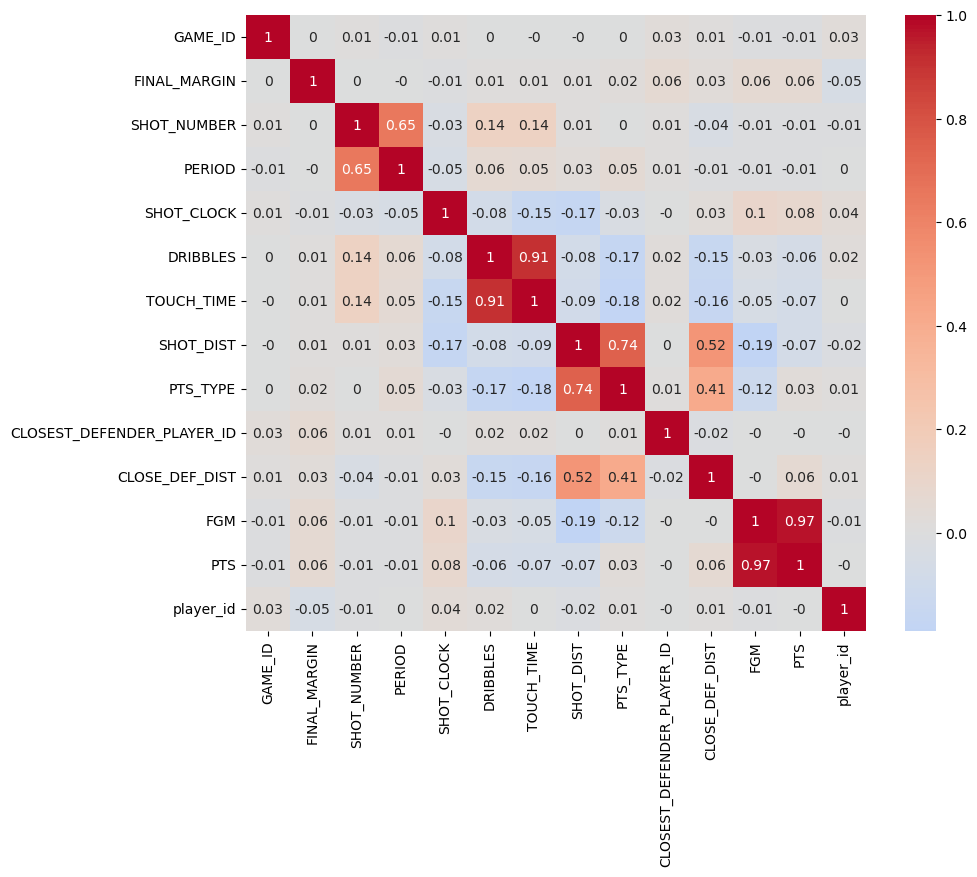

In [ ]:
numeric_corr = df.select_dtypes(include=['int64', 'float64']).corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', center=0)
plt.show()

As we can see 'SHOT_RESULTS' is really highly correlated with 'FGM' and 'PTS' so I will remove those 2.

In [ ]:
df = df.drop(columns=['FGM', 'PTS'])

In [ ]:
df.iloc[0]

GAME_ID                                       21400899
MATCHUP                       MAR 04, 2015 - CHA @ BKN
LOCATION                                             A
W                                                    W
FINAL_MARGIN                                        24
SHOT_NUMBER                                          1
PERIOD                                               1
GAME_CLOCK                                        1:09
SHOT_CLOCK                                        10.8
DRIBBLES                                             2
TOUCH_TIME                                         1.9
SHOT_DIST                                          7.7
PTS_TYPE                                             2
CLOSEST_DEFENDER_PLAYER_ID                      101187
CLOSE_DEF_DIST                                     1.3
player_id                                       203148
SHOT_RESULT                                       made
Name: 0, dtype: object

### DATA LEAKAGE

I will remove post-prediction columns 'W' and 'FINAL_MARGIN' to prevent data leakage.

In [ ]:
df = df.drop(columns=['W', 'FINAL_MARGIN'])

### IMPOSSIBLE CASES

I will remove impossible cases (incorrect data).

In [ ]:
df = df[df['TOUCH_TIME']>0]
df = df[df['SHOT_DIST']>0]
df = df[df['CLOSE_DEF_DIST']>0]

### CATEGORICAL FEATURES

I will change categorical features into numerical: 

'SHOT_RESULT' -> 'made': 1, 'missed': 0

'LOCATION' -> 'A': 0, 'H': 1

'PTS_TYPE' is categorical but doesn't require change into 0 and 1 because the values are already numerical and the actual numbers (2 and 3) have meaningful mathematical relationships that reflect the real scoring system.

In [ ]:
df['SHOT_RESULT'] = df['SHOT_RESULT'].map({'made': 1, 'missed': 0})
df['LOCATION'] = df['LOCATION'].map({'A': 0, 'H': 1})

I will transform 'PERIOD' with one-hot encoding because I think periods are not ordinal feature. This means that players's shooting doesn't increase or decrease through periods but can be bad in period 1, then good in periods 2 and 3, then again bad in period 4...

In [ ]:
period_dummies = pd.get_dummies(df['PERIOD'], prefix='PERIOD', drop_first=True, dtype=int)
df = df.drop(columns=['PERIOD'])
df = pd.concat([df, period_dummies], axis=1)

### FEATURE ENGINEERING

I will create or change some existing features in this part:

'GAME_CLOCK' into seconds

In [ ]:
def convert_to_seconds(time_str):
    if pd.isna(time_str):
        return None
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

In [ ]:
df['GAME_CLOCK'] = df['GAME_CLOCK'].apply(convert_to_seconds)

'MATCHUP' into 'DAY_OF_SEASON', 'PLAYER_TEAM' and 'DEFENDER TEAM'

In [ ]:
# Split MATCHUP into date and teams parts
df[['date_str', 'teams']] = df['MATCHUP'].str.split(' - ', expand=True)

# Convert dates
dates = pd.to_datetime(df['date_str'], format='%b %d, %Y')

# Calculate days since season start
days_since_start = (dates - dates.min()).dt.days

# Split teams (they're all in format "TEAM1 @ TEAM2" or "TEAM1 vs. TEAM2")
df[['team1', 'team2']] = df['teams'].str.extract(r'(\w+) [@vs.] (\w+)')

# Assign teams based on LOCATION
player_team = np.where(df['LOCATION'] == 1, df['team2'], df['team1'])
defender_team = np.where(df['LOCATION'] == 1, df['team1'], df['team2'])

# Add new features to df
df['DAY_OF_SEASON'] = days_since_start
df['PLAYER_TEAM'] = player_team
df['DEFENDER_TEAM'] = defender_team

df = df.drop(columns=['MATCHUP', 'date_str', 'teams', 'team1', 'team2'])

In [ ]:
# Create one-hot encoding for PLAYER_TEAM
player_team_dummies = pd.get_dummies(df['PLAYER_TEAM'], prefix='PLAYER_TEAM', drop_first=True)

# Create one-hot encoding for DEFENDER_TEAM
defender_team_dummies = pd.get_dummies(df['DEFENDER_TEAM'], prefix='DEFENDER_TEAM', drop_first=True)

# Concatenate the original dataframe with the new dummy variables
df = pd.concat([df, player_team_dummies, defender_team_dummies], axis=1)

df = df.drop(columns=['PLAYER_TEAM', 'DEFENDER_TEAM'])

In [ ]:
df.iloc[0]

GAME_ID              21400899.0
LOCATION                    0.0
FINAL_MARGIN               24.0
SHOT_NUMBER                 1.0
GAME_CLOCK                 69.0
                        ...    
DEFENDER_TEAM_SAC           0.0
DEFENDER_TEAM_SAS           0.0
DEFENDER_TEAM_TOR           0.0
DEFENDER_TEAM_UTA           0.0
DEFENDER_TEAM_WAS           0.0
Name: 0, Length: 79, dtype: float64

### MISSING VALUES

In [ ]:
df.isnull().sum()[df.isnull().sum()>0]

SHOT_CLOCK    5278
dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Create mask for missing values
shot_clock_missing = df['SHOT_CLOCK'].isnull()

# Create feature matrix excluding SHOT_RESULT and SHOT_CLOCK
features = df.drop(['SHOT_RESULT', 'SHOT_CLOCK'], axis=1)

# Handle categorical variables (if any)
features = pd.get_dummies(features)

# Create separate training data (where SHOT_CLOCK is not null)
X_train = features[~shot_clock_missing]
y_train = df['SHOT_CLOCK'][~shot_clock_missing]

# Create data to predict (where SHOT_CLOCK is null)
X_predict = features[shot_clock_missing]

# Initialize and train Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

# Make predictions
predictions = rfr.predict(X_predict)

# Fill in the missing values
df.loc[shot_clock_missing, 'SHOT_CLOCK'] = predictions

# BZVZ MODEL !!!

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [ ]:
df.columns

Index(['GAME_ID', 'LOCATION', 'FINAL_MARGIN', 'SHOT_NUMBER', 'GAME_CLOCK',
       'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id',
       'SHOT_RESULT', 'PERIOD_2', 'PERIOD_3', 'PERIOD_4', 'PERIOD_5',
       'PERIOD_6', 'PERIOD_7', 'DAY_OF_SEASON', 'PLAYER_TEAM_BKN',
       'PLAYER_TEAM_BOS', 'PLAYER_TEAM_CHA', 'PLAYER_TEAM_CHI',
       'PLAYER_TEAM_CLE', 'PLAYER_TEAM_DAL', 'PLAYER_TEAM_DEN',
       'PLAYER_TEAM_DET', 'PLAYER_TEAM_GSW', 'PLAYER_TEAM_HOU',
       'PLAYER_TEAM_IND', 'PLAYER_TEAM_LAC', 'PLAYER_TEAM_LAL',
       'PLAYER_TEAM_MEM', 'PLAYER_TEAM_MIA', 'PLAYER_TEAM_MIL',
       'PLAYER_TEAM_MIN', 'PLAYER_TEAM_NOP', 'PLAYER_TEAM_NYK',
       'PLAYER_TEAM_OKC', 'PLAYER_TEAM_ORL', 'PLAYER_TEAM_PHI',
       'PLAYER_TEAM_PHX', 'PLAYER_TEAM_POR', 'PLAYER_TEAM_SAC',
       'PLAYER_TEAM_SAS', 'PLAYER_TEAM_TOR', 'PLAYER_TEAM_UTA',
       'PLAYER_TEAM_WAS', 'DEFENDER_TEAM_BKN', 'DEFENDER_TEAM_BOS',
    

In [ ]:
X = df.drop(columns=['SHOT_RESULT'])
y = df['SHOT_RESULT']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=48)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train XGBoostClassifier
xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)

# Print results
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6178

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.85      0.71      3421
           1       0.64      0.33      0.44      2767

    accuracy                           0.62      6188
   macro avg       0.63      0.59      0.57      6188
weighted avg       0.62      0.62      0.59      6188



In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))


Feature Importance:
              feature  importance
8           SHOT_DIST    0.226686
11     CLOSE_DEF_DIST    0.087112
7          TOUCH_TIME    0.050532
5          SHOT_CLOCK    0.039147
2        FINAL_MARGIN    0.030782
..                ...         ...
37    PLAYER_TEAM_NOP    0.000000
41    PLAYER_TEAM_PHI    0.000000
48    PLAYER_TEAM_WAS    0.000000
42    PLAYER_TEAM_PHX    0.000000
77  DEFENDER_TEAM_WAS    0.000000

[78 rows x 2 columns]


In [ ]:
# Odaberite 5 najvažnijih varijabli
top_features = feature_importance.nlargest(4, 'importance')['feature'].tolist()

# Kreirajte novi X dataset samo s top 5 varijabli
X = df[top_features]
y = df['SHOT_RESULT']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=100)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train XGBoostClassifier
xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)

# Print results
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6220

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.87      0.71      3378
           1       0.67      0.33      0.44      2810

    accuracy                           0.62      6188
   macro avg       0.64      0.60      0.58      6188
weighted avg       0.64      0.62      0.59      6188

